In [3]:
from __future__ import division

import numpy as np
import networkx as nx

from sklearn.metrics import pairwise_distances

In [4]:
!ls | grep gml

dolphins_labelled.gml
embedded_ccsb.gml
embedded_collins.gml
embedded_dolphin.gml
embedded_florentine_families.gml
embedded_football.gml
embedded_hi_ii_14.gml
embedded_ito_core.gml
embedded_karate.gml
embedded_lc_multiple.gml
embedded_network_69.gml
embedded_polbooks.gml
embedded_pollbooks.gml
embedded_yeast_reactome.gml
embedded_yeast_uetz.gml
embedded_yeast_uetz_rel.gml
embedded_yeast_uetz_wang.gml
embedded_yeast_union.gml
embedded_yeast_union_rel.gml
football.gml
polbooks.gml


In [5]:
# start with karate club graph
# G = nx.karate_club_graph()
G = nx.read_gml("embedded_football.gml")
# G = nx.read_edgelist("reactome_edgelist.txt")
G = max(nx.connected_component_subgraphs(G), key=len)

In [21]:
# parameters 
eta = 5
alpha = 1
beta = 1
lam = 1e8

eps = 1e-8

# dimension of embedding
m = 50

# number of communities
k = 50

In [22]:
# a priori information about network

# number of nodes
N = nx.number_of_nodes(G)

# number of edges
e = nx.number_of_edges(G)

# adjacency matrix
A = np.array(nx.adjacency_matrix(G).todense())

# node degrees
degrees = nx.degree(G).values()

# first order similarity
S1 = A

#second order similarity
S2 = 1 - pairwise_distances(A, metric="cosine")

# similarity matrix 
S = S1 + eta * S2

# modularity matrix
B1 = np.array([[(degrees[i] * degrees[j]) / (2 * e) for j in range(N)] for i in range(N)])
B = A - B1

In [23]:
# initialise matrices 

w = 1

# basis matrix
M = np.random.rand(N, m) * w

# representation matrix
U = np.random.rand(N, m) * w

# community membership matrix
H = np.random.rand(N, k) * w

# community representation matrix 
C = np.random.rand(k, m) * w

In [24]:
# parameter updates

num_iter = 1000

similarities = np.zeros(num_iter)
communities = np.zeros(num_iter)
modularities = np.zeros(num_iter)
scores = np.zeros(num_iter)

for i in range(num_iter):
    
    # update M
    M = M * np.dot(S, U) / (np.dot(np.dot(M, U.T), U) + eps)
    
    if np.any(M < 0):
        print "M is negative"
        break
    
    if np.isnan(M).any():
        print "M IS NAN"
        break
    
    # update U
    U = U * np.transpose( (np.dot(M.T, S) + alpha * np.dot(C.T, H.T)) / \
                 (np.dot( (np.dot(M.T, M) + alpha * (np.dot(C.T, C))), U.T) + eps) )
    
    if np.any(U < 0):
        print "U is negative"
#         U[U < 0] = 0 
        break
    
    if np.isnan(U).any():
        print "U IS NAN"
        break
        
    # update C
    C = C * np.dot(H.T, U) / (np.dot(np.dot(C, U.T), U) + eps)
    
    if np.any(C < 0):
        print "C is negative"
        break
    
    if np.isnan(C).any():
        print "C IS NAN"
        break
    
    # update H
    delta = 2 * beta * np.dot(B1, H) * np.dot(B1, H) + 16 * lam * np.dot(np.dot(H, H.T), H) * \
            (2 * beta * np.dot(A, H) + 2 * alpha * np.dot(U, C.T) + (4 * lam - 2 * alpha) * H)
    
    if np.any(delta) < 0:
        print "delta is negative"
        break
    
    if np.isnan(delta).any():
        print "delta IS NAN"
        break
        
    if np.isinf(delta).any():
        print "delta is inf"
        break
        
    # before square root    
    h = (-2 * beta * np.dot(B1, H) + np.sqrt(delta)) / \
                    (8 * lam * np.dot(np.dot(H, H.T), H) + eps)
        
    if np.any(h < 0):
#         print "negative before square root"
        h[h < 0] = 0
#         print delta
#         print 
#         print -2 * beta * B1.dot(H)
#         print 
#         print -2 * beta * np.dot(B1, H) + np.sqrt(delta)
#         break
    
    H = H * np.sqrt(h)
    
    if np.any(H < 0):
        print "H is negative"
        break
    
    if np.isnan(H).any():
        print "H IS NAN"
        break
        
#     print np.linalg.norm(M)
#     print np.linalg.norm(U)
#     print np.linalg.norm(C)
#     print np.linalg.norm(H)
    
    # estimate quality of embedding
#     print "iteration={}".format(i)

    similarity = np.linalg.norm(S - np.dot(M, U.T), ord="fro") ** 2
    similarities[i] = similarity
#     print "similarity={}".format(similarity)

    community = alpha * np.linalg.norm(H - np.dot(U, C.T), ord="fro") ** 2
    communities[i] = community
#     print "community={}".format(community)

    Q = - beta * np.trace(np.dot(np.dot(H.T, B), H))
    modularities[i] = Q
#     print "modularity={}".format(Q)

    f = similarity + community + Q    
    scores[i] = f
#     print "f={}".format(f)
#     print

    

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

In [26]:
print scores[0]
print scores[-1]

18584.3349289
172.753406233


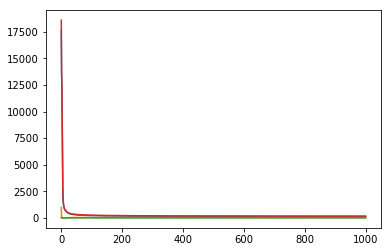

In [27]:
plt.plot(range(num_iter), similarities)
plt.plot(range(num_iter), communities)
plt.plot(range(num_iter), modularities)
plt.plot(range(num_iter), scores)

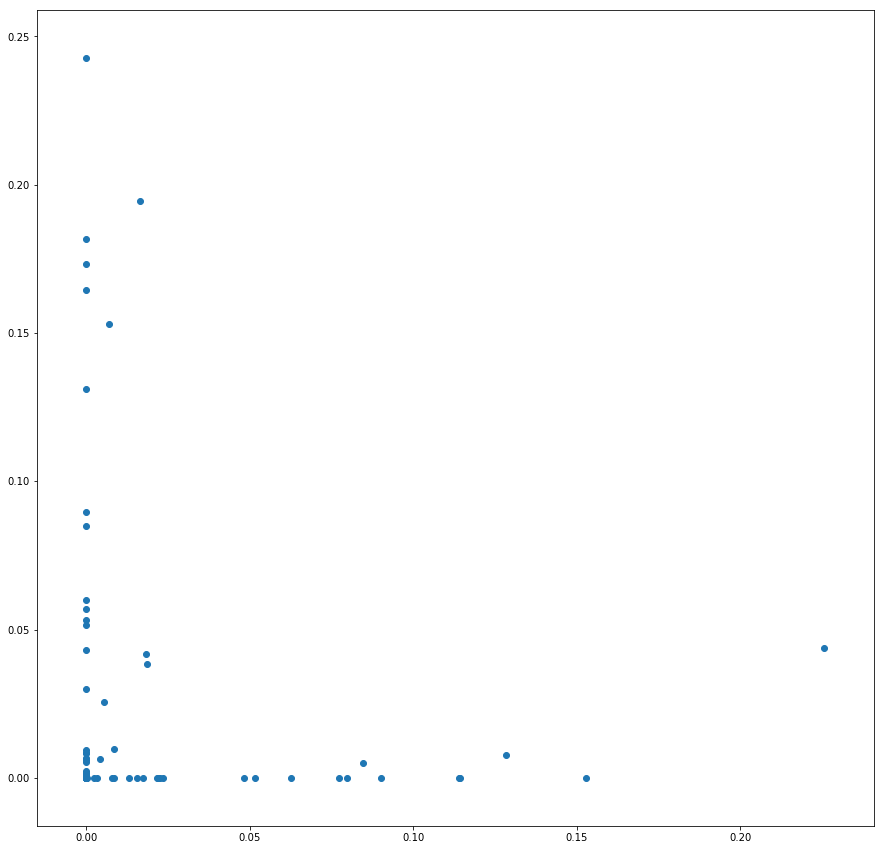

In [28]:
fig, ax = plt.subplots(figsize=(15, 15))

nodes = np.array(G.nodes())

# for x, y, n in zip(U[:,0], U[:,1], G.nodes()):
#     ax.annotate(n, xy = (x, y), xytext=(x, y))
# for n1, n2 in G.edges():
#     i, = np.where(nodes == n1)
#     j, = np.where(nodes == n2)
#     ax.plot(U[(i, j), 0], U[(i, j), 1], c="k")

ax.scatter(U[:,0], U[:,1])    

In [29]:
D = pairwise_distances(U)

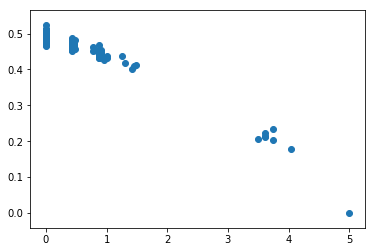

In [30]:
plt.scatter(S[0], D[0])

In [31]:
from scipy.stats import pearsonr

np.array([pearsonr(S[i], D[i])[0] for i in range(len(S))]).mean()

-0.96911626286719776

In [32]:
from sklearn.cluster import KMeans

In [33]:
kmeans = KMeans(n_clusters=13, max_iter=10000)

In [34]:
kmeans.fit(U)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
    n_clusters=13, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [35]:
kmeans_pred = kmeans.predict(U)

In [37]:
true_labels = nx.get_node_attributes(G, "value").values()

In [38]:
from sklearn.metrics import normalized_mutual_info_score

In [39]:
normalized_mutual_info_score(true_labels, kmeans_pred)

0.91508627912880447

In [23]:
from sklearn.manifold import SpectralEmbedding

In [24]:
sp = SpectralEmbedding(n_components=2)

In [25]:
G = nx.read_edgelist("Uetz_screen.txt")
G = max(nx.connected_component_subgraphs(G), key=len)
A = nx.adjacency_matrix(G)